In [4]:
import numpy as np
import pandas as pd
import math
import scipy.stats as stats
from sklearn.calibration import calibration_curve, CalibrationDisplay
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.utils import resample
import seaborn as sns

In [5]:
xdf = pd.read_csv("ukbiobankinstance0.csv")

In [6]:
xdf5 = xdf
# Exclude participants lost to followup and didn't have a non fatal CVD event
xdf5 = xdf5[(xdf5["dropout"] == 0) | (xdf5["non fatal CVD event 5 years"] == 1)]

# Exclude participants that died for other causes and didn't have a non fatal CVD event
xdf5 = xdf5[(xdf5["death other causes 5 years"] != 1) | (xdf5["non fatal CVD event 5 years"] == 1)]

In [7]:
def checkForNull(evidence: dict, key: str) -> bool:
    return evidence.get(key) is not None
#collects atributes using the key of the collumn
def getAtribute(evidence: dict, key: str) -> float:
    if checkForNull(evidence, key):
        return evidence.get(key)
    else:
        return -99


#Unused function but can be used to improve seswoa if mean and sd are known
def ranktovalues(percentile: float, mean: float, sd: float) -> float:
    # Calculate standard deviation
    std = (sd[0]-sd[1]) / 4
    p = percentile/100
    # Calculate actual values for each percentile using the inverse CDF (percent-point function) for a normal distribution
    actual_value = stats.norm.ppf(p, loc=mean, scale=sd)
    return actual_value
#defines the treshold of cardiovascular risk based on age and returns 1 if the participants risk factor is above the treshold
def applyranking(age: int, score: float)-> int:
    if age < 50:
        treshold = 0.025
    if age >= 50 and age <70:
        treshold = 0.05
    if age >= 70 and age < 80:
        treshold = 0.075
    if score >= treshold:
        return 1
    else:
        return 0       

In [82]:
class Models:
    # Calculates the base score for a participant, using the formula provided from the github    
    def carrier(evidence: dict, baseline_risk: float = 0.009783585) -> float:
        exSmoker = getAtribute(evidence, "ex smokers")
        bpmeds = getAtribute(evidence, 'bp medication')
        lipidmodifyingagents = getAtribute(evidence, "cholesterol medication")
        champscore = getAtribute(evidence, "champscore")
        eetscore = getAtribute(evidence, "eetscore")
        diabetesint = getAtribute(evidence, "diabetes")
        seswoa = getAtribute(evidence, "seswoa")
        gender = (getAtribute(evidence, "sex"))
        age = getAtribute(evidence, "age")
        smoking = getAtribute(evidence, "current smokers")
        sbp = getAtribute(evidence, "sbp")
        if getAtribute(evidence, "total cholesterol") == -99:
            #placeholder for totalcholesterol
            tc = 4.63484
        else:
            tc = getAtribute(evidence, "total cholesterol")
        if getAtribute(evidence, "hdl") == -99:
            #placeholder for hdl
            hdl = 1.3286
        else:
            hdl = getAtribute(evidence, "hdl")
        preexistingCVD = getAtribute(evidence, "prior CVD")
#        result = (1 - (math.pow(1- baseline_risk, math.exp(
#                0.05873692 * (age - 59.63795) + 0.46032031 * gender + 0.39404609 * diabetesint + 0.68281002 
#                    * preexistingCVD + -0.41203031 * (seswoa - 0.0602643) + 0.74567125 * smoking + 0.15477294 
#                    * exSmoker + -0.00120839 * (champscore - 5.433716) + -0.00231330 * (eetscore - 84.15415) 
#                    + 0.00808079 * (sbp - 133.0301) + 0.12838867 * (tc - 5.220962) + -0.47619288 * (hdl - 1.557978)
#                    + 0.42483205 * bpmeds + -0.34413909 * lipidmodifyingagents))))
        if(diabetesint == 1):
            linear_predictor = 0.49553209 * (age - 62.74) / 8.76 \
                    + 0.45815892 * gender \
                    + 0.81137903 * preexistingCVD \
                    - 0.10819498 * (seswoa - 0.113) / 0.2863089 \
                    + 0.67996922 * smoking \
                    + 0.10704490 * exSmoker \
                    - 0.01678731 * (champscore - 4.33) / 4.17 \
                    - 0.06064829 * (eetscore - 80.52) / 14.91 \
                    + 0.11947157 * (sbp - 141.3) / 17.59 \
                    + 0.20443736 * (tc - 4.481) / 1.03358 \
                    - 0.22427392 * (hdl - 1.293) / 0.3880579 \
                    + 0.34326524 * bpmeds \
                    - 0.19612272 * lipidmodifyingagents \
                    + 0.45264684 * diabetesint

        else:
            linear_predictor = 0.49553209 * (age - 58.61) / 8.76 \
                    + 0.45815892 * gender \
                    + 0.81137903 * preexistingCVD \
                    - 0.10819498 * (seswoa - 0.05947) / 0.2797443 \
                    + 0.67996922 * smoking \
                    + 0.10704490 * exSmoker \
                    - 0.01678731 * (champscore - 5.75) / 4.43 \
                    - 0.06064829 * (eetscore - 84.96) / 15.25 \
                    + 0.11947157 * (sbp - 130.8) / 17.27 \
                    + 0.20443736 * (tc - 5.409) / 1.028514 \
                    - 0.22427392 * (hdl - 1.618) / 0.4701247 \
                    + 0.34326524 * bpmeds \
                    - 0.19612272 * lipidmodifyingagents
        result = 1 - (math.pow(1- baseline_risk, math.exp(linear_predictor)))
        return result
    #score2 evaluation function. calculation taken from the supplementary material from this paper
    #https://academic.oup.com/eurheartj/article/42/25/2439/6297709#377893934
    def score2(evidence: dict) -> float:
        gender = getAtribute(evidence, "sex")
        age = getAtribute(evidence, "age")
        cage = (age-60)/5
        smoking = getAtribute(evidence, "current smokers")
        sbp = getAtribute(evidence, "sbp")
        csbp = (sbp-120)/20
        if getAtribute(evidence, "total cholesterol") == -99:
            tc = 4.63484
        else:
            tc = getAtribute(evidence, "total cholesterol")
        if getAtribute(evidence, "hdl") == -99:
            hdl = 1.3286
        else:
            hdl = getAtribute(evidence, "hdl")
        ctc =(tc-6)/1
        chdl = (hdl-1.3)/0.5
        bpmeds = getAtribute(evidence, 'bp medication')
        #gender female = 0 and male = 1
        if gender == 1:
            basesurv = 0.9605
            linear_predictor = 0.3742*cage+0.6012*smoking+0.2777*csbp+0.1458*ctc+-0.2698*chdl+-0.0755*(cage*smoking)+-0.0255*(csbp*cage)+-0.0281*(ctc*cage)+0.0426*(chdl*cage)
        if gender == 0:
            basesurv = 0.9776
            linear_predictor = 0.4648*cage+0.7744*smoking+0.3131*csbp+0.1002*ctc+-0.2606*chdl+-0.1088*(cage*smoking)+-0.0277*(csbp*cage)+-0.0226*(ctc*cage)+0.0613*(chdl*cage)
        uncalresult = 1 - basesurv**math.exp(linear_predictor)
        result = 1-math.exp(-math.exp(-0.5699+0.7476* math.log(-math.log(1-uncalresult))))
        return result
   
    #framingham score calculator taken from the following url:
    #https://www.framinghamheartstudy.org/fhs-risk-functions/cardiovascular-disease-10-year-risk/
    def framingham(evidence: dict)-> float:
        gender = getAtribute(evidence, "sex")
        age = getAtribute(evidence, "age")
        smoking = getAtribute(evidence, "current smokers")
        sbp = getAtribute(evidence, "sbp")
        bpmeds = getAtribute(evidence, 'bp medication')
        diabetesint = getAtribute(evidence, "diabetes")
        if getAtribute(evidence, "total cholesterol") == -99:
            #placeholder for totalcholesterol
            tc = 4.63484
        else:
            tc = getAtribute(evidence, "total cholesterol")
        if getAtribute(evidence, "hdl") == -99:
            #placeholder for hdl
            hdl = 1.3286
        else:
            hdl = getAtribute(evidence, "hdl")
        #framingham uses mg/dL while carrier and score2 model use mmol/L for the cholesterol values
        #the following conversion is applied
        ctc = tc*38.67
        chdl = hdl*38.67
        if gender == 0: # Females
            basesurv = 0.95012
            if bpmeds == 0:
                sbpbeta =2.76157
            else:
                sbpbeta =2.82263
            linear_combo = math.log(age)*2.32888+math.log(ctc)*1.20904+math.log(chdl)*-0.70833 + math.log(sbp)*sbpbeta+smoking*0.52873+diabetesint*0.69154
            result = 1 - (math.pow(basesurv, math.exp(linear_combo-26.1931)))
        if gender == 1: # Males
            basesurv = 0.88936
            if bpmeds == 0:
                sbpbeta =1.93303
            else:
                sbpbeta =1.99881
            linear_combo = math.log(age)*3.06117+math.log(ctc)*1.12370+math.log(chdl)*-0.93263+math.log(sbp)*sbpbeta+smoking*0.65451+diabetesint*0.57367
            result = 1 - (math.pow(basesurv, math.exp(linear_combo -23.9802)))
        return result
    
    def ascvd(evidence: dict)-> float:
        age = getAtribute(evidence, "age")
        gender = (getAtribute(evidence, "sex"))
        diabetesint = getAtribute(evidence, "diabetes")
        current_smoker = getAtribute(evidence, "current smokers")
        sbp = getAtribute(evidence, "sbp")
        bpmeds = getAtribute(evidence, 'bp medication')
        tc = getAtribute(evidence, "total cholesterol")
        if tc == -99:
            tc = 4.63484
        tc = tc * 38.67
        hdl = getAtribute(evidence, "hdl")
        if hdl == -99:
            hdl = 1.3286
        hdl = hdl * 38.67
        if(gender == 0): # female
            baseline_risk = 0.9665
            linear_predictor = -29.799 * math.log(age) \
                               + 4.884 * math.log(age)*math.log(age) \
                               + 13.540 * math.log(tc) \
                               - 3.114 * math.log(age)*math.log(tc) \
                               - 13.578 * math.log(hdl) \
                               + 3.149 * math.log(age)*math.log(hdl) \
                               + (2.019 * bpmeds + 1.957 * (1-bpmeds)) * math.log(sbp) \
                               + 7.574 * current_smoker \
                               - 1.665 * math.log(age) * current_smoker + \
                               + 0.661 * diabetesint \
                               + 29.18
        else:
            baseline_risk = 0.9144
            linear_predictor = 12.344 * math.log(age) \
                               + 11.853 * math.log(tc) \
                               - 2.664 * math.log(age)*math.log(tc) \
                               - 7.990 * math.log(hdl) \
                               + 1.769 * math.log(age)*math.log(hdl) \
                               + (1.797 * bpmeds + 1.764 * (1-bpmeds)) * math.log(sbp) \
                               + 7.837 * current_smoker \
                               - 1.795 * math.log(age) * current_smoker + \
                               + 0.658 * diabetesint \
                               - 61.18
        result = 1-math.pow(baseline_risk, math.exp(linear_predictor))
        return result

In [83]:
# Women (Example: 55 years of age with total cholesterol 213 mg/dL, HDL–C 50 mg/dL, untreated systolic BP 120 mm Hg, nonsmoker, and without diabetes) 
test = {"age" : 55, 
        "sex": 0, 
        "total cholesterol" : 213 / 38.67, #in mmol/L
        "hdl" : 50 / 38.67, #in mmol/L
        "bp medication": 0, 
        "sbp": 120, 
        "diabetes" : 0, 
        "current smokers" : 0}
# Expected risk 2.1%
print(Models.ascvd(test))
# Men (Example: 55 years of age with total cholesterol 213 mg/dL, HDL–C 50 mg/dL, untreated systolic BP 120 mm Hg, nonsmoker, and without diabetes)
test = {"age" : 55, 
        "sex": 1, 
        "total cholesterol" : 213 / 38.67, #in mmol/L
        "hdl" : 50 / 38.67, #in mmol/L
        "bp medication": 0, 
        "sbp": 120, 
        "diabetes" : 0, 
        "current smokers" : 0}
# Expected risk 5.3%
print(Models.ascvd(test))

0.02052229820249485
0.05384421997908706


In [85]:
#small sanity check moment
test = {"age" : 53, 
        "sex": 1, 
        "seswoa": 0.375, 
        "current smokers" : 0, 
        "ex smokers": 0,
        "champscore": 3, 
        "eetscore": 80, 
        "sbp": 125, 
        "total cholesterol" : 161 / 38.67, #in mmol/L
        "hdl" : 55 / 38.67, #in mmol/L
        "cholesterol medication" : 0, 
        "bp medication": 1, 
        "diabetes" : 1,
        "prior CVD" : 0}
print(Models.carrier(test))
print(Models.score2(test))
print(Models.framingham(test))
print(Models.ascvd(test))

0.014039497508356868
0.026473184987820142
0.15622654200203556
0.0689673780190081


In [86]:
#run the classifiers for 5 year event prediction
xdf5["carrier 5 years"]                = xdf5.apply(lambda x: Models.carrier(dict(x), 0.009783585), axis = 1)
xdf5["score2 5 years"]                 = xdf5.apply(lambda x: Models.score2(dict(x)), axis = 1)
xdf5["framingham 5 years"]             = xdf5.apply(lambda x: Models.framingham(dict(x)), axis = 1)
xdf5["ascvd 5 years"]                  = xdf5.apply(lambda x: Models.ascvd(dict(x)), axis = 1)

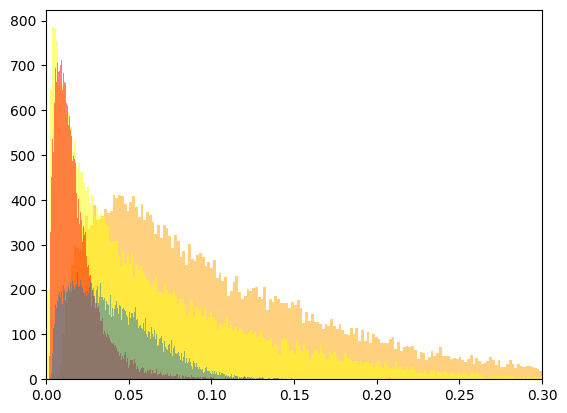

In [92]:
plt.hist(xdf5["framingham 5 years"], bins = 500, alpha = 0.5, color = 'orange')
plt.hist(xdf5["ascvd 5 years"],      bins = 500, alpha = 0.5, color = 'yellow')
plt.hist(xdf5["carrier 5 years"],    bins = 500, alpha = 0.5, color = 'red')
plt.hist(xdf5["score2 5 years"],     bins = 500, alpha = 0.5)
plt.xlim(0, 0.30)
plt.show()

In [12]:
# Function to calculate bootstrap AUC confidence intervals
def bootstrap_auc(y_true, y_pred, n_bootstraps=1000, ci=0.95):
    bootstrapped_scores = []
    np.random.seed(42)  # for reproducibility
    
    # Run bootstrap
    for _ in range(n_bootstraps):
        # Resample with replacement
        indices = resample(np.arange(len(y_true)), replace=True)
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample
            continue
        
        score = metrics.roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    
    # Calculate the lower and upper percentile
    sorted_scores = np.sort(bootstrapped_scores)
    lower_percentile = (1.0 - ci) / 2.0
    upper_percentile = 1.0 - lower_percentile
    
    confidence_lower = sorted_scores[int(lower_percentile * len(sorted_scores))]
    confidence_upper = sorted_scores[int(upper_percentile * len(sorted_scores))]
    
    return confidence_lower, confidence_upper

In [93]:
#Get the true positive rate and false positive rate from the models
y5 = xdf5["CVD event 5 years"]
preds_carrier_model = xdf5["carrier 5 years"]

fpr_carrier, tpr_carrier, threshold_carrier = metrics.roc_curve(y5, preds_carrier_model)
roc_auc_carrier = metrics.auc(fpr_carrier, tpr_carrier)
roc_auc_carrier_CI_lower, roc_auc_carrier_CI_upper = bootstrap_auc(y5.values, preds_carrier_model.values)

preds_score2 = xdf5["score2 5 years"]
fpr_score2, tpr_score2, threshold_score2 = metrics.roc_curve(y5, preds_score2)
roc_auc_score2 = metrics.auc(fpr_score2, tpr_score2)
roc_auc_score2_CI_lower, roc_auc_score2_CI_upper = bootstrap_auc(y5.values, preds_score2.values)

preds_framingham = xdf5["framingham 5 years"]
fpr_framingham, tpr_framingham, threshold_framingham = metrics.roc_curve(y5, preds_framingham)
roc_auc_framingham = metrics.auc(fpr_framingham, tpr_framingham)
roc_auc_framingham_CI_lower, roc_auc_framingham_CI_upper = bootstrap_auc(y5.values, preds_framingham.values)

preds_ascvd = xdf5["ascvd 5 years"]
fpr_ascvd, tpr_ascvd, threshold_ascvd = metrics.roc_curve(y5, preds_ascvd)
roc_auc_ascvd = metrics.auc(fpr_ascvd, tpr_ascvd)
roc_auc_ascvd_CI_lower, roc_auc_ascvd_CI_upper = bootstrap_auc(y5.values, preds_ascvd.values)


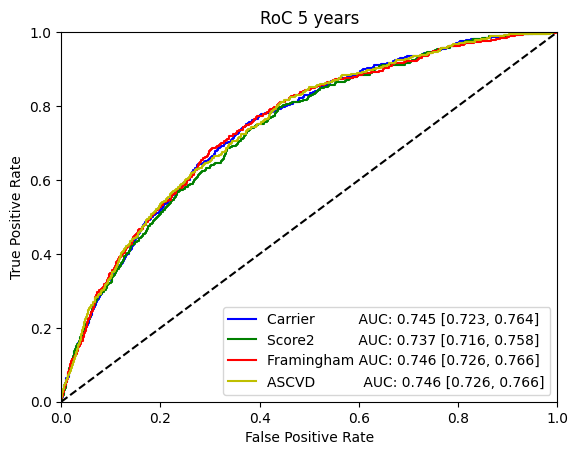

In [95]:
#plot the RoC of the models for events within 10 years
plt.plot(fpr_carrier, tpr_carrier,       'b', label = f"Carrier          AUC: {roc_auc_carrier:.3f} [{roc_auc_carrier_CI_lower:.3f}, {roc_auc_carrier_CI_upper:.3f}]")
plt.plot(fpr_score2, tpr_score2,         'g', label = f"Score2          AUC: {roc_auc_score2:.3f} [{roc_auc_score2_CI_lower:.3f}, {roc_auc_score2_CI_upper:.3f}]")
plt.plot(fpr_framingham, tpr_framingham, 'r', label = f"Framingham AUC: {roc_auc_framingham:.3f} [{roc_auc_framingham_CI_lower:.3f}, {roc_auc_framingham_CI_upper:.3f}]")
plt.plot(fpr_ascvd, tpr_ascvd,           'y', label = f"ASCVD          AUC: {roc_auc_ascvd:.3f} [{roc_auc_ascvd_CI_lower:.3f}, {roc_auc_ascvd_CI_upper:.3f}]")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("RoC 5 years")
plt.show()

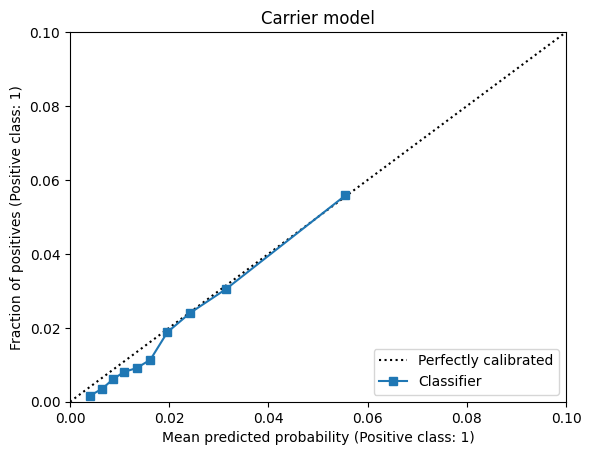

Text(0.5, 1.0, 'ASCVD model')

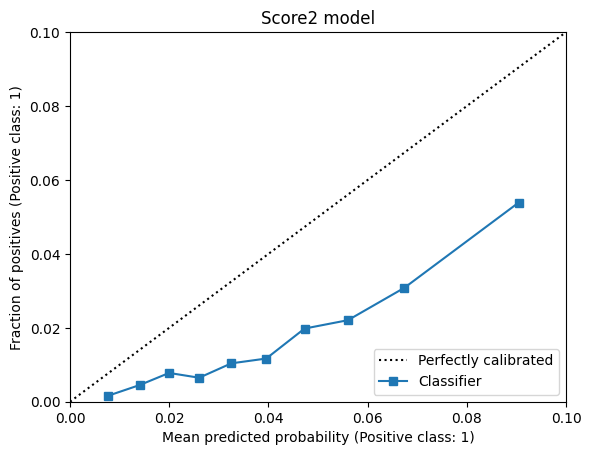

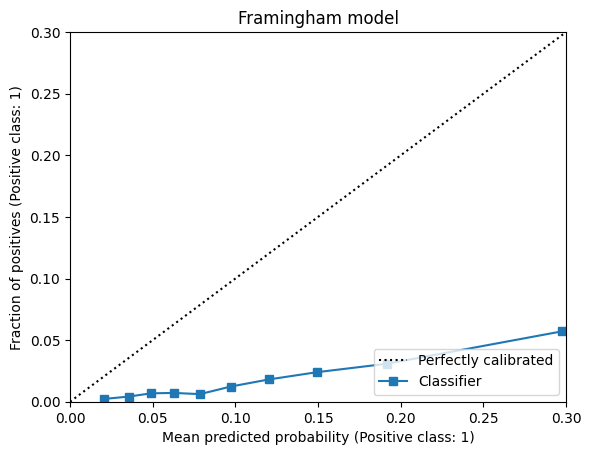

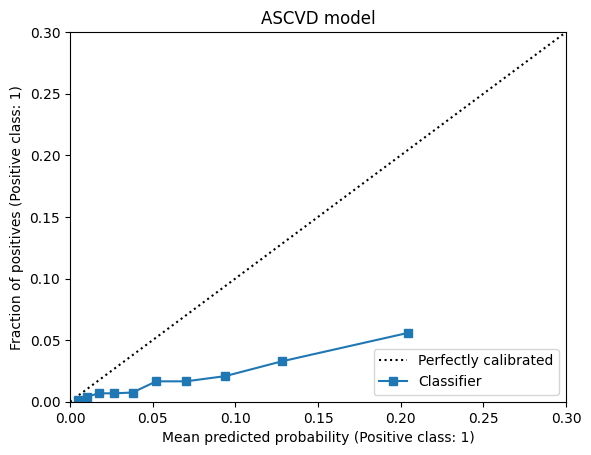

In [96]:
CalibrationDisplay.from_predictions(y5, preds_carrier_model, n_bins = 10, strategy = "quantile")
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.title("Carrier model")
plt.show()
CalibrationDisplay.from_predictions(y5, preds_score2, n_bins = 10, strategy = "quantile")
plt.xlim(0, 0.1)
plt.ylim(0, 0.1)
plt.title("Score2 model")
CalibrationDisplay.from_predictions(y5, preds_framingham, n_bins = 10, strategy = "quantile")
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.title("Framingham model")
CalibrationDisplay.from_predictions(y5, preds_ascvd, n_bins = 10, strategy = "quantile")
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.title("ASCVD model")

In [98]:
xdf10 = xdf
# Exclude participants lost to followup and didn't have a non fatal CVD event
xdf10 = xdf10[(xdf5["dropout"] == 0) | (xdf10["non fatal CVD event 10 years"] == 1)]

# Exclude participants that died for other causes and didn't have a non fatal CVD event
xdf10 = xdf10[(xdf10["death other causes 10 years"] != 1) | (xdf5["non fatal CVD event 10 years"] == 1)]
xdf10 = xdf10.reset_index()
xdf10["carrier 10 years"] = xdf10.apply(lambda x: Models.carrier(dict(x), 0.0215404), axis = 1)
xdf10["score2 10 years"] = xdf10.apply(lambda x: Models.score2(dict(x)), axis = 1)
xdf10["framingham 10 years"] = xdf10.apply(lambda x: Models.framingham(dict(x)), axis = 1)
xdf10["ascvd 10 years"] = xdf10.apply(lambda x: Models.ascvd(dict(x)), axis = 1)

In [99]:
#Get the true positive rate and false positive rate from the models
y10 = xdf10["CVD event 10 years"]
preds_carrier_model = xdf10["carrier 10 years"]

fpr_carrier, tpr_carrier, threshold_carrier = metrics.roc_curve(y10, preds_carrier_model)
roc_auc_carrier = metrics.auc(fpr_carrier, tpr_carrier)
roc_auc_carrier_CI_lower, roc_auc_carrier_CI_upper = bootstrap_auc(y10.values, preds_carrier_model.values)

preds_score2 = xdf10["score2 10 years"]
fpr_score2, tpr_score2, threshold_score2 = metrics.roc_curve(y10, preds_score2)
roc_auc_score2 = metrics.auc(fpr_score2, tpr_score2)
roc_auc_score2_CI_lower, roc_auc_score2_CI_upper = bootstrap_auc(y10.values, preds_score2.values)

preds_framingham = xdf10["framingham 10 years"]
fpr_framingham, tpr_framingham, threshold_framingham = metrics.roc_curve(y10, preds_framingham)
roc_auc_framingham = metrics.auc(fpr_framingham, tpr_framingham)
roc_auc_framingham_CI_lower, roc_auc_framingham_CI_upper = bootstrap_auc(y10.values, preds_framingham.values)

preds_ascvd = xdf10["ascvd 10 years"]
fpr_ascvd, tpr_ascvd, threshold_ascvd = metrics.roc_curve(y10, preds_ascvd)
roc_auc_ascvdm = metrics.auc(fpr_ascvd, tpr_ascvd)
roc_auc_ascvd_CI_lower, roc_auc_ascvd_CI_upper = bootstrap_auc(y10.values, preds_ascvd.values)


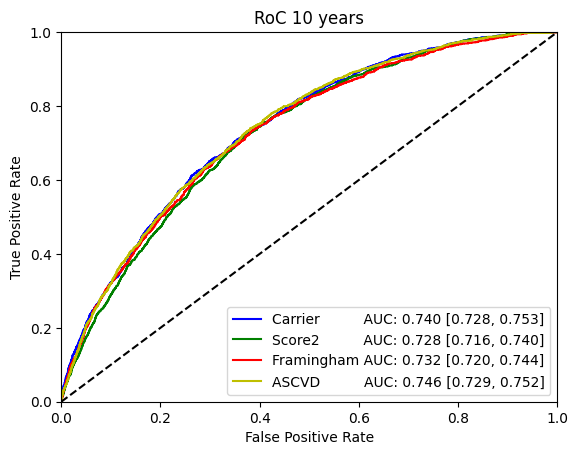

In [100]:
#plot the RoC of the models for events within 10 years
plt.plot(fpr_carrier, tpr_carrier,       'b', label = f"Carrier          AUC: {roc_auc_carrier:.3f} [{roc_auc_carrier_CI_lower:.3f}, {roc_auc_carrier_CI_upper:.3f}]")
plt.plot(fpr_score2, tpr_score2,         'g', label = f"Score2          AUC: {roc_auc_score2:.3f} [{roc_auc_score2_CI_lower:.3f}, {roc_auc_score2_CI_upper:.3f}]")
plt.plot(fpr_framingham, tpr_framingham, 'r', label = f"Framingham AUC: {roc_auc_framingham:.3f} [{roc_auc_framingham_CI_lower:.3f}, {roc_auc_framingham_CI_upper:.3f}]")
plt.plot(fpr_ascvd, tpr_ascvd,           'y', label = f"ASCVD          AUC: {roc_auc_ascvd:.3f} [{roc_auc_ascvd_CI_lower:.3f}, {roc_auc_ascvd_CI_upper:.3f}]")
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("RoC 10 years")
plt.show()

Text(0.5, 1.0, 'ASCVD model')

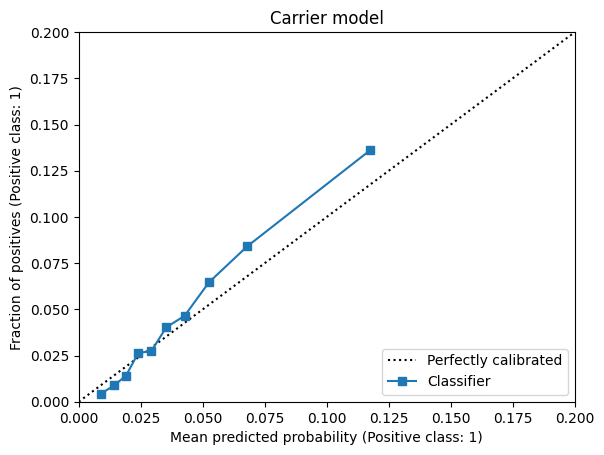

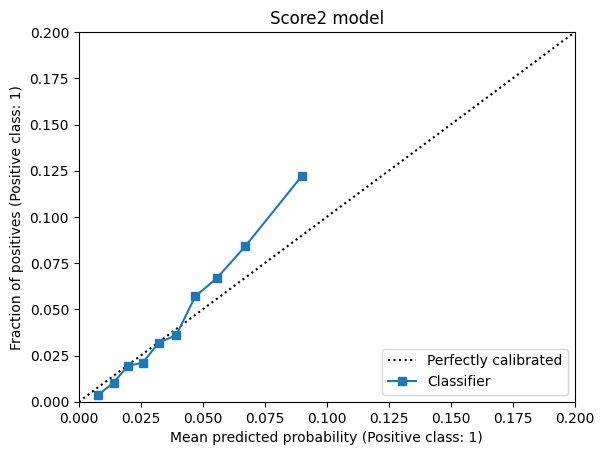

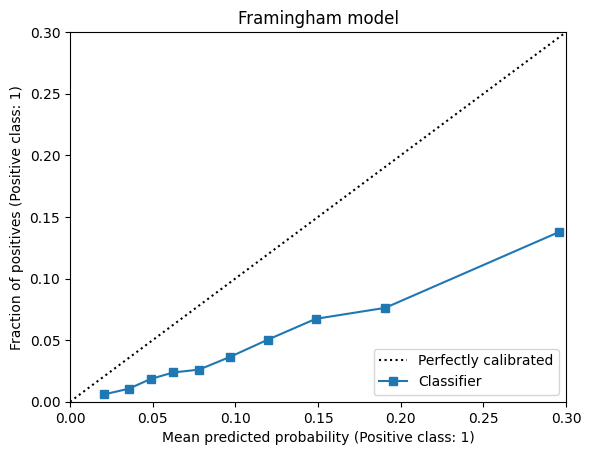

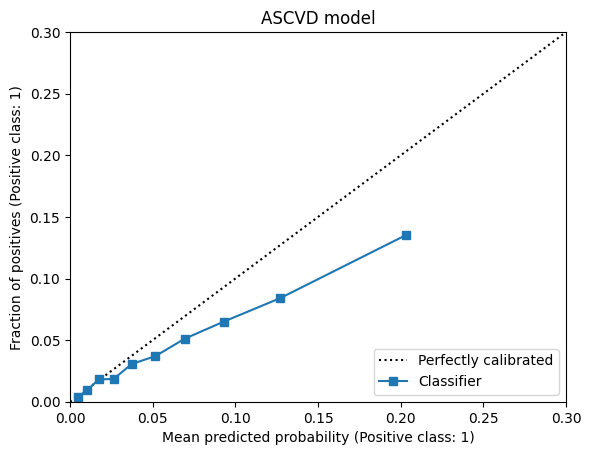

In [101]:
CalibrationDisplay.from_predictions(y10, preds_carrier_model, n_bins = 10, strategy = "quantile")
plt.xlim(0, 0.2)
plt.ylim(0, 0.2)
plt.title("Carrier model")
CalibrationDisplay.from_predictions(y10, preds_score2, n_bins = 10, strategy = "quantile")
plt.xlim(0, 0.2)
plt.ylim(0, 0.2)
plt.title("Score2 model")
CalibrationDisplay.from_predictions(y10, preds_framingham, n_bins = 10, strategy = "quantile")
#CalibrationDisplay.from_predictions(y10[xdf10['sex']==0], preds_framingham[xdf10['sex']==0], n_bins = 10, strategy = "quantile")
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.title("Framingham model")
CalibrationDisplay.from_predictions(y10, preds_ascvd, n_bins = 10, strategy = "quantile")
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.title("ASCVD model")